In [115]:
import sys
sys.path.append('..')
from Map import Map

from glob import glob
import os
from pathlib import Path
import shutil
import urllib.request as request
from contextlib import closing

import matplotlib.pyplot as plt
import pygrib
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
from metpy.units import units
from datetime import datetime, timedelta
from dateutil import tz

In [116]:
grib_dir = Path('.') / 'data'
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'models' / 'href'

In [131]:
# Download files

date = 20220706
run = '06'
fhr = '21'
left_lon = 360-90
right_lon = 360-77
top_lat = 36
bottom_lat = 24

nomads_url = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_hrefconus.pl?'
              f'file=href.t{run}z.conus.pmmn.f{fhr}.grib2'
              '&all_lev=on&var_APCP=on'
              f'&subregion=&leftlon={left_lon}&rightlon={right_lon}&toplat={top_lat}&bottomlat={bottom_lat}&'
              f'dir=/href.{date}/ensprod')

def download_gribfilter(file_url):
    with closing(request.urlopen(file_url)) as r:
        with open(f'{grib_dir}/href/href.t{run}z.conus.pmmn.precip.f{fhr}.grib2', 'wb') as f:
            shutil.copyfileobj(r, f)
        
download_gribfilter(nomads_url)

In [132]:
#%%capture
# Read in files and acquire data needed for plotting
ds = pygrib.open(f'{grib_dir}/href/href.t{run}z.conus.pmmn.precip.f{fhr}.grib2')

# Reset the grib messages to 0 so you're at beginning of the file
ds.seek(0)

for g in ds:
    print(g)

# Get grib message
# For reference, here are the corresponding grib messages with QPF exceedance
# 1 = 1-hour total precip, 2 = 3-hour total precip
ds = ds[2]

# Extract lats, lons, and data values
lats, lons = ds.latlons()
href_values = ds.values

# Attach units
href_values = units('mm') * href_values
href_values = href_values.to('in')

def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time lapse in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + timedelta(0,rounding-seconds,-dt.microsecond)

def convert_datetime(pygrib_time: str) -> str:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    
    # Handle weird issue where a valid time of 00Z is in format
    # YYYYMMDD H
    # All other valid times are in format YYYYMMDDHHMM
    if pygrib_time.split(' ')[1] == '0': 
        utc_time = datetime.strptime(pygrib_time, '%Y%m%d %H').replace(tzinfo=from_zone)
    else:
        utc_time = datetime.strptime(pygrib_time, '%Y%m%d %H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    eastern = roundTime(eastern)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

# Get the date and time of the forecast
dt = str(ds.validityDate) + ' ' + str(ds.validityTime)
VALID_TIME = convert_datetime(dt)

1:Total Precipitation:kg m**-2 (accum):lambert:surface:level 0:fcst time 20-21 hrs (accum):from 202207060600:weighted ens mean
2:Total Precipitation:kg m**-2 (accum):lambert:surface:level 0:fcst time 18-21 hrs (accum):from 202207060600:weighted ens mean


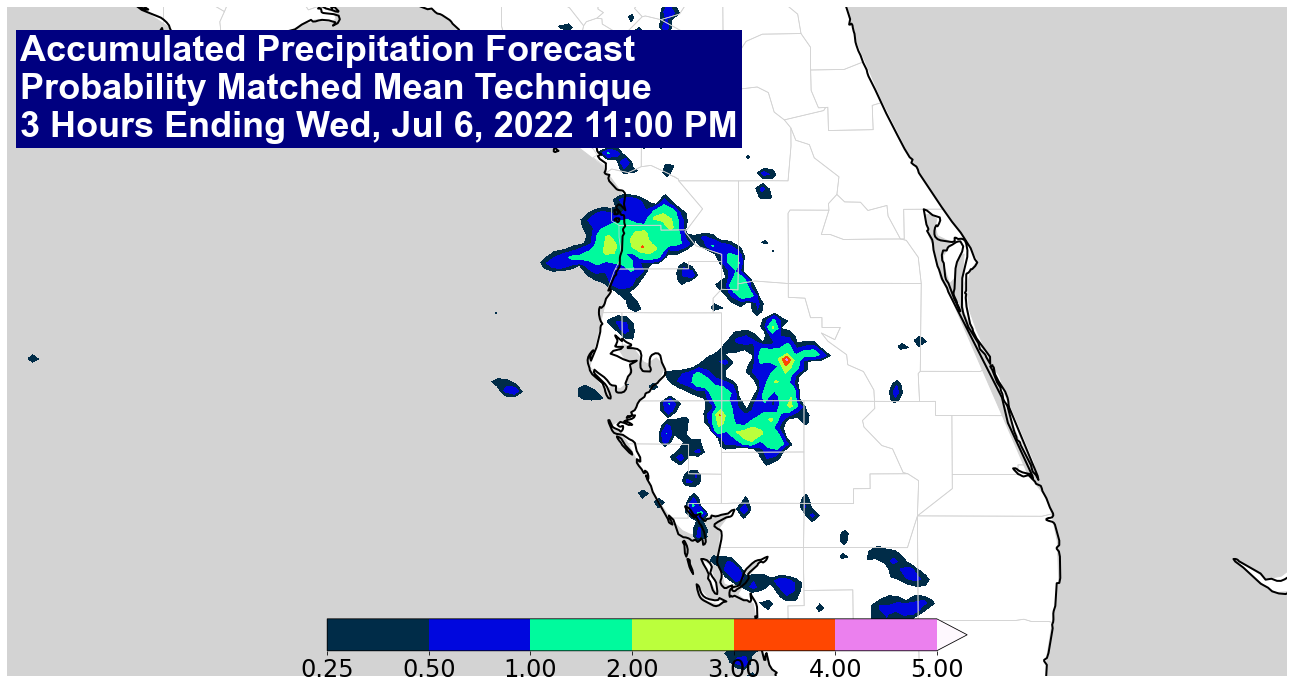

In [133]:
new_map = Map('tampa_area')
new_map.add_counties()
fig, ax = new_map.make_map()

data_range = [0.25, 0.50, 1.00, 2.00, 3.00, 4.00, 5.00]
contour = ax.contourf(lons, lats, href_values, data_range, cmap=plt.cm.gist_ncar, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Make the axis title
ax.set_title(f'Accumulated Precipitation Forecast\nProbability Matched Mean Technique\n3 Hours Ending {VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=36, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01, zorder=5,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
plt.savefig(f'{graphics_dir}/precip-pmmn-3hr_{fhr}.png', dpi=72)
plt.show()